In [1]:
from google.colab import drive

drive.mount('/content/drive')
#!mkdir dataset
#!pip install gdown
#!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
#!mv refcocog.tar.gz ./dataset/
#!curl -L -o refcocog.tar.g "https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq"
#!mv refcocog.tar.gz ./dataset/
#!sudo install curl
import tarfile
data_dir='/content/drive/MyDrive/ColabNotebooks/refcocog.tar.gz'
# Extract data
tar = tarfile.open(data_dir)
tar.extractall('dataset/')

Mounted at /content/drive


In [2]:
!tar -xf dataset/refcocog.tar.gz -C dataset
!ls dataset


tar: dataset/refcocog.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
refcocog


In [3]:
!pip install git+https://github.com/openai/CLIP.git
from clip import clip

model, preprocess = clip.load("RN50")

model = model.float()

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-eqp2aumi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-eqp2aumi
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=1828b3e0547089a52374e0495da165e636cd7ba8119883826dfd9f178c0440d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-3xs_vwz2/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


100%|███████████████████████████████████████| 244M/244M [00:05<00:00, 48.4MiB/s]


In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<1024>"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
os.environ["TORCH_USE_CUDA_DSA"]="1"

In [5]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import ops
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import autocast, GradScaler
from posixpath import split
import json
import tarfile
import io
import pickle
from PIL import Image
import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import chain




# import some common libraries
import cv2
#from google.colab.patches import cv2_imshow
# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = {}


In [6]:
def preProcess_datasets(data_dir):
  train_dataset = {}
  test_dataset = {}
  f = open(f'{data_dir}/annotations/refs(umd).p', 'rb')
  data['refs'] = pickle.load(f)
  instances_file = os.path.join(f'{data_dir}/annotations/instances.json')
  instances = json.load(open(instances_file, 'r'))
  data['images'] = instances['images']
  data['annotations'] = instances['annotations']

  c=0
  d=0
  for key,val in enumerate(data['refs']):
    for v in data['images']:
      if val['image_id'] == v['id']:
        fname = os.path.join(data_dir+'/images/', v['file_name'])
        if os.path.exists(fname):
          if val['split'] == 'train' or val['split'] == 'val':
            train_dataset[c] = {}
            train_dataset[c]['image'] = v['file_name']
            train_dataset[c]['captions'] = [t['sent'] for t in val['sentences']]
            train_dataset[c]['id'] = val['image_id']
            break
          else:
            if d>=5000:
                break
            test_dataset[d] = {}
            test_dataset[d]['image'] = v['file_name']
            test_dataset[d]['captions'] = [t['sent'] for t in val['sentences']]
            test_dataset[d]['id'] = val['image_id']
            break
    for ann in data['annotations']:
      if val['ann_id'] == ann['id']:
        if val['split'] == 'train' or val['split'] == 'val':
          train_dataset[c]['bbox'] = ann['bbox']
          c+=1
          break
        else:
          if d>=5000:
            break
          test_dataset[d]['bbox'] = ann['bbox']
          d+=1
          break
    if c>=5000:
      break

  return train_dataset, test_dataset


def resize_bounding_box(bbox, original_size, new_size):
  x_min, y_min, x_max, y_max = bbox
  orig_width, orig_height = original_size
  new_width, new_height = new_size

  # Calculate the scaling factors
  width_ratio = new_width / orig_width
  height_ratio = new_height / orig_height

  # Resize the bounding box coordinates
  new_x_min = int(x_min * width_ratio)
  new_y_min = int(y_min * height_ratio)
  new_x_max = int(x_max * width_ratio)
  new_y_max = int(y_max * height_ratio)

  return new_x_min, new_y_min, new_x_max, new_y_max

def xywh_to_xyxy(boxes):
  xmin = boxes[0]
  ymin = boxes[1]
  w = boxes[2]
  h = boxes[3]
  xmax = xmin + w
  ymax = ymin + h
  return [xmin, ymin, xmax, ymax]


def normalize_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    #remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    #replace numbers
    text = re.sub(r'\d+', "[NUM]", text)

    return text

In [7]:
class RefCOCOgDataset(Dataset):
    def __init__(self, dataset, transform, target_transform, data_dir='dataset/refcocog'):
        super(RefCOCOgDataset, self).__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.dataset = dataset



    def __getitem__(self, idx):
        data_item = {}
        fname = os.path.join(self.data_dir+'/images/', self.dataset[idx]['image'])
        image = Image.open(fname).convert('RGB')
        shape_0 = list(image.size)
        if self.transform:
            data_item['image'] = self.transform(image).float()
        if self.target_transform:
            data_item['captions'] = clip.tokenize([self.target_transform(sent) for sent in self.dataset[idx]['captions']]).float()
            bb = xywh_to_xyxy(self.dataset[idx]['bbox'])
            bbox = resize_bounding_box(bb, shape_0, [640,640])
            data_item['bbox'] = torch.FloatTensor(bbox)
        return data_item


    def __len__(self):
        return len(self.dataset)



In [8]:
def _make_grid(input):
    # Get the width and height of the output feature map
    _, width, height = input.size()
    # Determine the size of each grid cell
    grid_size = height // 4
    grid_cells = []
    grid_coordinates = []
    for i in range(4):
        for j in range(4):
            # Calculate the coordinates for the current grid cell
            x1 = i * grid_size
            y1 = j * grid_size
            x2 = x1 + grid_size
            y2 = y1 + grid_size
            # Extract the region corresponding to the grid cell
            grid_cell = input[ :, x1:x2, y1:y2]
            grid_coordinates.append(torch.FloatTensor([float(x1),float(y1),float(x2),float(y2)]))
            grid_cells.append(grid_cell)
    grid_cells = torch.stack(grid_cells)
    grid_coordinates = torch.stack(grid_coordinates)
    return grid_cells, grid_coordinates


class Grid(torch.nn.Module):
    def __init__(self):
        super(Grid, self).__init__()

    def forward(self, x):
        res = []
        for img in x:
            res.append(_make_grid(img))
        return res


class CustomCLIP(torch.nn.Module):
  def __init__(self, num_classes: int = 4, bias=True):
    super(CustomCLIP, self).__init__()
    self.num_classes = num_classes
    self.conv = model.visual.float().conv1
    self.bn = model.visual.float().bn1
    self.relu = model.visual.float().relu1
    self.pool = model.visual.float().avgpool
    self.fc1 = torch.nn.Linear(119072, self.num_classes, bias=bias)
    self.fc2 = torch.nn.Linear(512, self.num_classes, bias=bias)
    self.flttn = torch.nn.Flatten()
    self.tok_emb = model.token_embedding
    self.dropout = torch.nn.Dropout(0.1)

    torch.nn.init.kaiming_uniform_(self.conv.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
    #torch.nn.init.zeros_(self.conv.bias)

    # Initialize parameters for batch normalization layer
    torch.nn.init.ones_(self.bn.weight)
    torch.nn.init.zeros_(self.bn.bias)


    # Initialize parameters for the linear layer
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)


    # Initialize parameters for the linear layer
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc2.bias)

    self.text_encoder = torch.nn.Sequential(
      self.tok_emb,
      self.fc2,
      self.dropout,
    )


    self.grid = Grid()

    # add a bottleneck
    self.image_encoder = torch.nn.Sequential(
      self.conv,
      self.bn,
      self.relu,
      self.dropout,
      self.pool,
      self.flttn,
      self.fc1,
      self.dropout,

    )


  def forward(self, img, cap):
    grids = self.grid(img)
    similar = []
    boxes = grids[0][1]
    for idx, (gd, _) in enumerate(grids):
      x_ = []
      for g in gd:
          x = F.interpolate(g.unsqueeze(0), size=(244, 244), mode='bilinear', align_corners=False)
          x = self.image_encoder(x)
          x = torch.norm(x, dim=-1, keepdim=True)
          x_.append(x)
      text = cap[idx].unsqueeze(0).to(torch.int32)
      y = self.text_encoder(text)
      #y = y[:, :, :, :4]
      y = torch.norm(y, dim=-1, keepdim=True)


      im_ = torch.stack(x_)


      target_len = im_.size(0) - y.size(1)
      y = F.pad(im_, (0,target_len,0,0), value=0)
      y = y.view(-1, 1)
      #y = y[:, :, 0].unsqueeze(-1)





      similarity = (100.0 * im_ @ y.mT).softmax(dim=0)
      top_values, top_indices = similarity.topk(1, dim=0)
      #boxes = grids[idx][0][1]
      selected_box = boxes[top_indices.to(boxes.device)]

      similar.append(selected_box.squeeze())

    out_bbox = torch.stack(similar)
    #out_bbox_ = out_bbox.view(80, 4)
    out_bbox = out_bbox[:, 0, :]
    #out_bbox = out_bbox.view(-1, 4)

    return out_bbox

  def parameters(self, recurse: bool = True):
    return self.get_modified_model_parameters(recurse)

  def get_modified_model_parameters(self, recurse: bool = True):
    leaf_param_nodes = []
    for name, param in self.named_parameters(recurse=recurse):
      if param.requires_grad and param.is_leaf:
        leaf_param_nodes.append(param)
    return leaf_param_nodes


In [9]:
# instantiate the network and move it to the chosen device (GPU)
modified_model = CustomCLIP(num_classes=4).float().to(device)

In [10]:
def get_cost_function():
  cost_function = torch.nn.SmoothL1Loss()
  return cost_function


In [11]:
def get_optimizer(model, lr, wd, momentum, eps):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd, eps=eps)

    return optimizer

In [12]:
def training_step(net, data_loader, optimizer, cost_function):
    with torch.set_grad_enabled(True):
        samples = 0.0
        cumulative_loss = 0.0
        cumulative_accuracy = 0.0
        batch_ious = []
        # set the network to training mode

        net.train()
        accumulation_steps = 2
        clip_value = 2.0
        #scaler = GradScaler()
        # iterate over the training set
        # Check requires_grad for each parameter

        for batch_idx, batch in enumerate(data_loader):
            #print(f"Input Data: {batch['image'].min()}, {batch['image'].max()}, {batch['captions'].max()}, {batch['captions'].max()}")
            # forward pass
            #with autocast():
                #load data into GPU
            batch['image'] = batch['image'].to(device)
            batch['captions'] = batch['captions'].to(device)
            target_bbox = batch['bbox'].to(device).requires_grad_()
            out_bbox = net(batch['image'], batch['captions']).to(device).requires_grad_()

            # loss computation
            loss = cost_function(out_bbox, target_bbox)
            loss = loss / accumulation_steps


            if torch.isnan(target_bbox).any() or torch.isnan(out_bbox).any() or torch.isnan(loss).any() or any(torch.isnan(p).any() for p in net.parameters()):
                print("NaN detected in loss or model parameters. Training stopped.")
                return
            if torch.isinf(target_bbox).any() or torch.isinf(out_bbox).any() or torch.isinf(loss).any() or any(torch.isinf(p).any() for p in net.parameters()):
                print("inf detected in loss or model parameters. Training stopped.")
                return

            #backward-pass
            loss.backward()


            if (batch_idx + 1) % accumulation_steps == 0:
                # Gradient scaling and optimization step
                torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value) #ommit this
                # parameters update
                optimizer.step()
                # gradients reset
                optimizer.zero_grad()

            else:
                continue


            # fetch prediction and loss value
            samples += batch['bbox'].shape[0]

            cumulative_loss += loss.sum().item()

            acc = torchvision.ops.box_iou(target_bbox, out_bbox).max(dim=1).values.sum().item()
            batch_ious.append(acc)




            # Calculate the average IoU across all batches
        if batch_ious:
            cumulative_accuracy = torch.mean(torch.tensor(batch_ious, dtype=float,device=device,requires_grad=True)).item()
        else:
            cumulative_accuracy = 0.0 # Set to zero if there are no elements

        average_loss = cumulative_loss / samples if samples > 0 else 0.0
    return average_loss, cumulative_accuracy

def test_step(net, data_loader, cost_function):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0
    batch_ious = []
    #net = net.float()
    # set the network to evaluation mode
    net.eval()

    # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
    with torch.no_grad():
        # iterate over the test set

        for batch_idx, batch in enumerate(data_loader):

            #load data into GPU
            batch['image'] = batch['image'].to(device)
            batch['captions'] = batch['captions'].to(device)
            target_bbox = batch['bbox'].to(device)

            # forward pass
            out_bbox = net(batch['image'], batch['captions']).to(device)

            # loss computation on GPU
            loss = cost_function(out_bbox, target_bbox)

            # accumulate the loss on the CPU
            cumulative_loss += loss.sum().item()

            samples += batch['bbox'].shape[0]

            acc = torchvision.ops.box_iou(target_bbox, out_bbox).max(dim=1).values.sum().item()
            batch_ious.append(acc)




            # Calculate the average IoU across all batches
        if batch_ious:
            cumulative_accuracy = torch.mean(torch.tensor(batch_ious, dtype=float,device=device,requires_grad=True)).item()
        else:
            cumulative_accuracy = 0.0  # Set to zero if there are no elements

        average_loss = cumulative_loss / samples if samples > 0 else 0.0
    return average_loss, cumulative_accuracy

In [13]:
def pad_sequence(batch):
  return torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)
def my_collate_fn(batch):

  return {
      'image': pad_sequence([x['image'] for x in batch]),
      'captions': pad_sequence([x['captions'] for x in batch]),
      'bbox': pad_sequence([x['bbox'] for x in batch])
      }


def get_data(data_dir, batch_size, test_batch_size, transform=True, target_transform=True):
    global transform_mat
    if transform:
        # convert the PIL images to Tensors
        transform_mat = T.Compose([
            T.Resize((640, 640)),
            T.RandomHorizontalFlip(),
            T.RandomRotation(degrees=30),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
          # prepare data transformations and then combine them sequentially
        transform_mat = None
    if target_transform:
        target_transform = normalize_text
    else:
        target_transform = None

  # load data
    global test_dataset
    train_dataset, test_dataset = preProcess_datasets(data_dir)

    full_training_data = RefCOCOgDataset(dataset=train_dataset, transform=transform_mat, target_transform=target_transform, data_dir=data_dir)



    test_data = RefCOCOgDataset(dataset=test_dataset, transform=transform_mat, target_transform=target_transform, data_dir=data_dir)
    num_samples = len(full_training_data)

    training_samples = int(num_samples * 0.8)
    validation_samples = num_samples - training_samples

    training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])
    print(len(training_data))

    print(len(validation_data))
    print(len(test_data))
    # initialize dataloaders_collate
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True, num_workers=2, collate_fn=my_collate_fn)
    val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False, num_workers=2, collate_fn=my_collate_fn)
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False, num_workers=2, collate_fn=my_collate_fn)

    return train_loader, val_loader, test_loader


In [14]:
# tensorboard logging utilities
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

In [15]:
# main funcition
def main(
      root='/content/dataset/refcocog/',
      data_dir='dataset/refcocog',
      batch_size=128,
      test_batch_size=128,
      num_classes=4,
      learning_rate=0.002,
      weight_decay=1e-5,
      eps=1e-8,
      momentum=0.9,
      epochs=10
    ):
    best_val_accuracy = 0.03  # Initialize to a low value
    best_epoch = -1
    writer = SummaryWriter(log_dir="runs/exp1")
    #global test_loader
    # train clip on zero-shot learning and instantiates dataloaders
    train_loader, val_loader, test_loader = get_data(data_dir=data_dir, batch_size=batch_size, test_batch_size=test_batch_size, transform=True, target_transform=True)

    # instantiate the optimizer
    optimizer = get_optimizer(modified_model, learning_rate, weight_decay, momentum, eps)

    # define the cost function
    cost_function = get_cost_function()

    #torch.cuda.empty_cache()
    # computes evaluation results before training
    print('Before training:')
    train_loss, train_accuracy = test_step(modified_model, train_loader, cost_function)
    val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)
    test_loss, test_accuracy = test_step(modified_model, test_loader, cost_function)

    # log to TensorBoard
    log_values(writer, -1, train_loss, train_accuracy, "train")
    log_values(writer, -1, val_loss, val_accuracy, "validation")
    log_values(writer, -1, test_loss, test_accuracy, "test")

    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')
    torch.cuda.empty_cache()

    # for each epoch, train the network and then compute evaluation results
    for e in range(epochs):
        train_loss, train_accuracy = training_step(modified_model, train_loader, optimizer, cost_function)
        val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)
        # logs to TensorBoard
        log_values(writer, e, val_loss, val_accuracy, "Validation")

        print('Epoch: {:d}'.format(e+1))
        print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
        print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
        print('-----------------------------------------------------')
        torch.cuda.empty_cache()

        # Check if current model has better validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = e
            #save the model
            torch.save(modified_model.state_dict(), 'best_model.pth')

    # compute final evaluation results
    print('After training:')

    #load saved model
    modified_model.load_state_dict(torch.load('best_model.pth'))

    train_loss, train_accuracy = test_step(modified_model, train_loader, cost_function)
    val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)
    test_loss, test_accuracy = test_step(modified_model, test_loader, cost_function)

    # log to TensorBoard
    log_values(writer, epochs, train_loss, train_accuracy, "train")
    log_values(writer, epochs, val_loss, val_accuracy, "validation")
    log_values(writer, epochs, test_loss, test_accuracy, "test")

    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')
    torch.cuda.empty_cache()


    # closes the logger
    writer.close()

In [16]:
main()

4000
1000
5000
Before training:
	Training loss 1.74982, Training accuracy 37.23
	Validation loss 1.75141, Validation accuracy 38.07
	Test loss 1.75886, Test accuracy 37.28
-----------------------------------------------------
Epoch: 1
	Training loss 0.79971, Training accuracy 36.62
	Validation loss 1.61012, Validation accuracy 38.38
-----------------------------------------------------
Epoch: 2
	Training loss 0.80023, Training accuracy 36.06
	Validation loss 1.54737, Validation accuracy 38.38
-----------------------------------------------------
Epoch: 3
	Training loss 0.80610, Training accuracy 36.26
	Validation loss 1.64411, Validation accuracy 38.36
-----------------------------------------------------
Epoch: 4
	Training loss 0.80005, Training accuracy 36.49
	Validation loss 1.63813, Validation accuracy 38.45
-----------------------------------------------------
Epoch: 5
	Training loss 0.80997, Training accuracy 36.68
	Validation loss 1.66633, Validation accuracy 38.43
-------------

In [26]:
def draw_bbx(bb, color='r'):
    bb = np.array(bb, dtype=np.float32)
    print(bb)
    return patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1],
                         linewidth=2, edgecolor=color, facecolor='none')


def inference(model, query, image, gd_bbox):

    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    with torch.no_grad():
        fname = os.path.join('dataset/refcocog/images/', image)
        image = Image.open(fname).convert('RGB')
        img = transform_mat(image).float()
        cap = clip.tokenize([normalize_text(sent) for sent in query]).float()

        bbox = model(img.unsqueeze(0).to(device), cap.unsqueeze(0).to(device))
        print('inference')
        print(gd_bbox)
        print(bbox)
        print(bbox.shape)
        out_bb = bbox.cpu().numpy()
        out_bb = out_bb.astype(int)
        print(out_bb)
        new_bb = resize_bounding_box(out_bb[0], [640, 640], list(image.size))
        plt.figure()
        # Assuming image is a PyTorch tensor
        img = img.permute(1,2,0)
        img_to_show = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
        plt.imshow(img_to_show)
        # Iterate over each bounding box
        '''for i in range(new_bb.shape[0]):
            current_bbox = new_bb[i]
            # Display the image with bounding box'''
        plt.gca().add_patch(draw_bbx(new_bb, 'r'))
        plt.axis('off')
        plt.show()


['woman in coveralls', 'a person wearing overalls']
inference
[496.24, 82.81, 82.8, 168.71]
tensor([[160., 320., 320., 480.]])
torch.Size([1, 4])
[[160 320 320 480]]
[160. 137. 320. 206.]


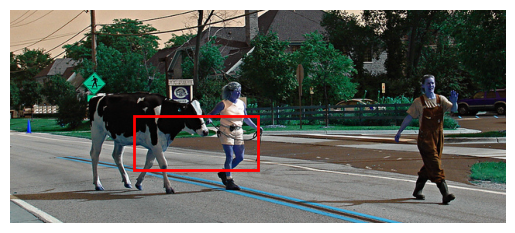

In [27]:
x = test_dataset[4]
print(x['captions'])

inference(modified_model,
             query=x['captions'],
             image=x['image'],
              gd_bbox=x['bbox'])
